In [101]:
import os
import re
import math
import typing
import warnings
from enum import Enum

import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import matplotlib as mpl
from scipy.stats import zscore
import matplotlib.pyplot as plt

import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.linear_model import Ridge, Lasso, LinearRegression, HuberRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import silhouette_score, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, train_test_split

from IPython.display import display, HTML
display(HTML("<style>.container { width: 90% !important}; </style>"))

In [2]:
warnings.filterwarnings(
    action='ignore',
    message='înternal gelsd'
)

warnings.filterwarnings(
    action='ignore',
    category=UserWarning
)

warnings.filterwarnings(
    action='ignore',
    category=RuntimeWarning
)

np.random.seed(1)

pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', 50)

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
# Matplotlib set label size
%matplotlib inline

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

plt.rc('font', size=12)
plt.rc('figure', figsize=(12, 5))

In [4]:
sns.set_style('whitegrid')
sns.set_context(
    'notebook',
    font_scale=1,
    rc={
        'lines.linewidth': 2,
        'font.family': [u'times']
    }
)

## Loading Data

In [5]:
train_set = pd.read_csv('./data/train_set.csv', index_col=0)
test_set = pd.read_csv('./data/test_set.csv', index_col=0)

<AxesSubplot:>

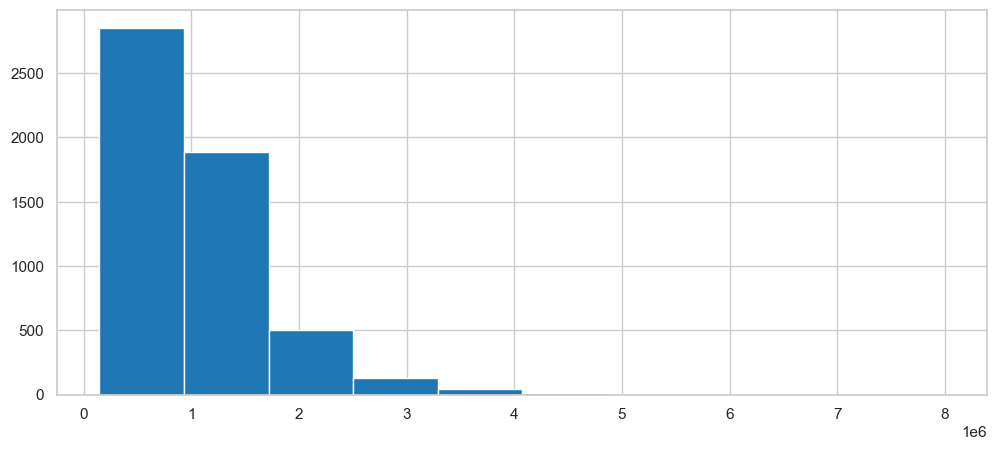

In [6]:
train_set.Price.hist()

<AxesSubplot:>

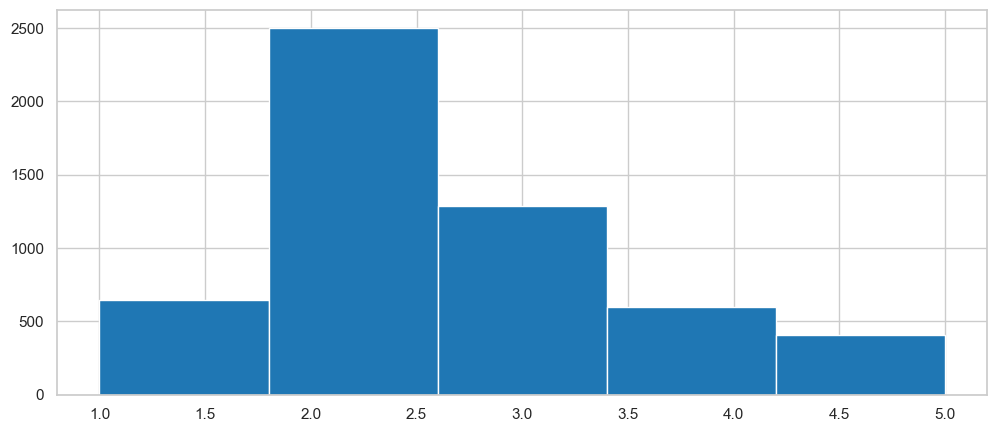

In [7]:
train_set['price_range'] = pd.cut(train_set.Price, bins=[.0, .5e6, 1e6, 1.5e6, 2e6, 10e6], labels=[1, 2, 3, 4, 5])
train_set['price_range'].hist(bins=5)

In [8]:
def train_val_split(train_set: pd.DataFrame, stratify_col: str = 'price_range'):
    train_set_target = train_set[stratify_col]

    X_train, X_valid, Y_train, Y_valid = train_test_split(
        train_set, 
        train_set_target, 
        stratify=train_set_target, 
        test_size=.15,
        random_state=0
    )
    
    return pd.concat([X_train, Y_train], axis=1), pd.concat([X_valid, Y_valid], axis=1)

In [9]:
train_set, valid_set = train_val_split(train_set)

## EDA

In [10]:
train_set.describe()

,Rooms,Price,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude,Propertycount
count,4617.000000,4.617000e+03,4617.000000,4617.000000,4617.000000,4617.000000,4595.000000,4617.000000,2435.000000,2801.000000,4617.000000,4617.000000,4617.000000
mean,2.938705,1.078467e+06,10.261057,3105.903617,2.918562,1.537362,1.631338,538.927442,167.292700,1965.311674,-37.810119,144.994463,7379.346979
std,0.951790,6.454600e+05,6.038494,94.448991,0.993194,0.699995,0.990320,1614.688646,917.783312,36.274513,0.079175,0.108455,4341.521714
min,1.000000,1.450000e+05,0.000000,3000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1830.000000,-38.174880,144.542370,389.000000
25%,2.000000,6.500000e+05,6.200000,3044.000000,2.000000,1.000000,1.000000,185.000000,92.000000,1940.000000,-37.857100,144.927500,4217.000000
50%,3.000000,9.000000e+05,9.200000,3084.000000,3.000000,1.000000,2.000000,451.000000,125.000000,1970.000000,-37.803500,144.999400,6543.000000
75%,3.000000,1.331000e+06,13.000000,3148.000000,3.000000,2.000000,2.000000,656.000000,175.000000,2000.000000,-37.757690,145.058790,10331.000000
max,8.000000,8.000000e+06,48.100000,3977.000000,20.000000,8.000000,10.000000,75100.000000,44515.000000,2018.000000,-37.408530,145.526350,21650.000000


<AxesSubplot:xlabel='Type', ylabel='count'>

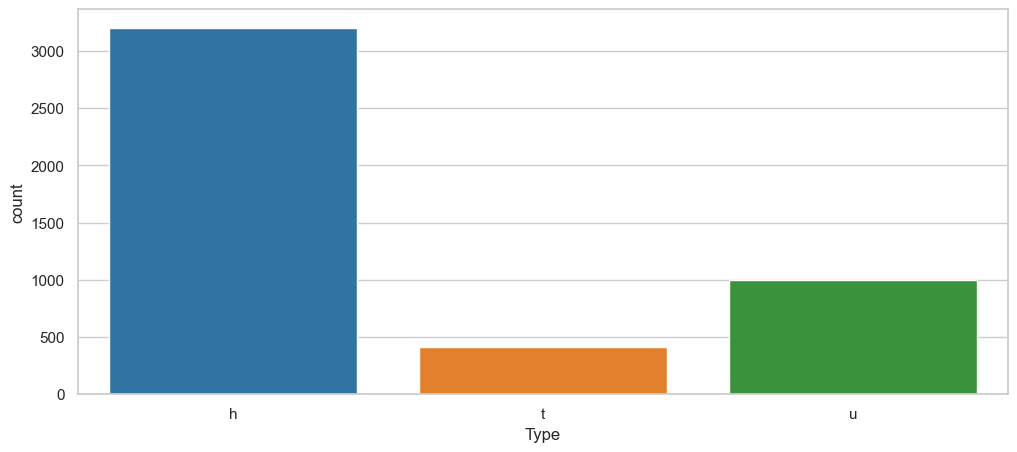

In [11]:
sns.countplot(x='Type', data=train_set)

<AxesSubplot:xlabel='Longtitude', ylabel='Lattitude'>

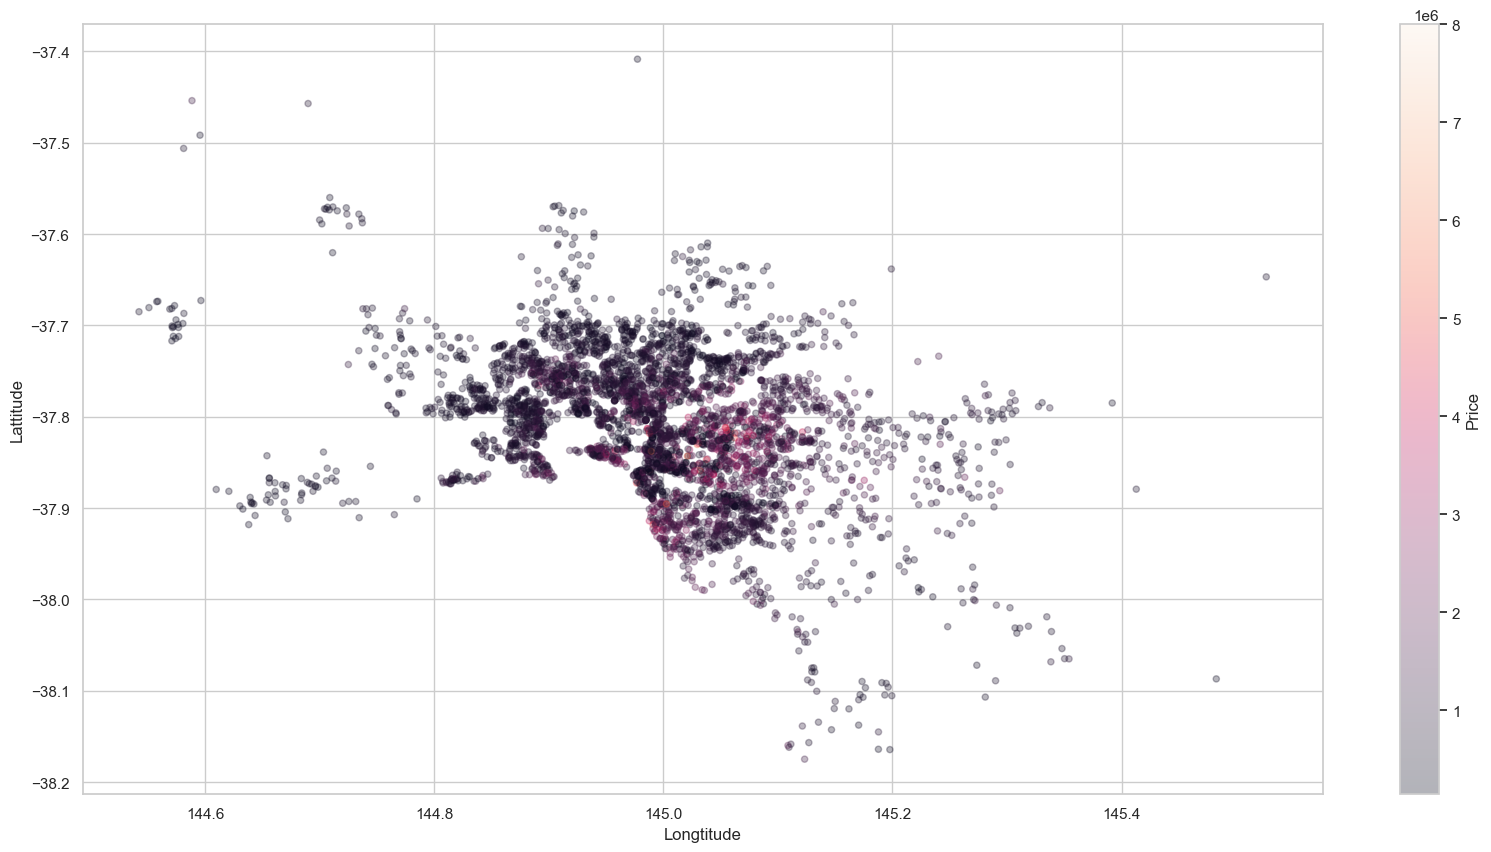

In [12]:
train_set.plot(
    kind='scatter',
    x='Longtitude',
    y='Lattitude',
    alpha=.3,
    figsize=(20, 10),
    c='Price', 
    cmap=plt.get_cmap('jet'),
    colorbar=True,
    sharex=False
)

<AxesSubplot:>

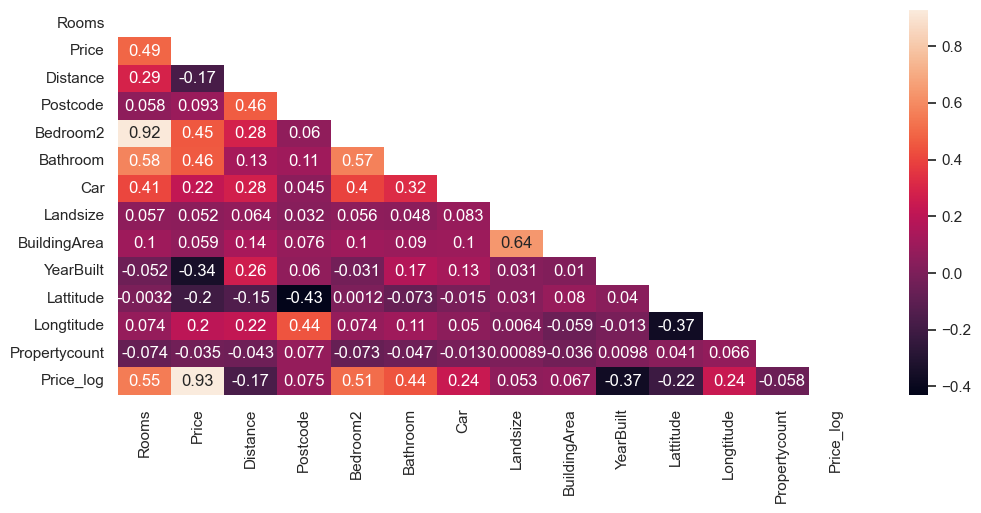

In [13]:
train_set.loc[:, 'Price_log'] = np.log(train_set['Price'])
corr = train_set.corr(numeric_only=True)

# Getting the Upper Triangle of the co-relation matrix
matrix = np.triu(corr)

sns.heatmap(
    corr,
    annot=True,
    mask=matrix
)

In [14]:
corr_sorted = corr['Price'].sort_values()
corr_sorted

YearBuilt       -0.344287
Lattitude       -0.204988
Distance        -0.174566
Propertycount   -0.035337
Landsize         0.051705
BuildingArea     0.059124
Postcode         0.092615
Longtitude       0.200117
Car              0.219901
Bedroom2         0.450831
Bathroom         0.457246
Rooms            0.488317
Price_log        0.927824
Price            1.000000
Name: Price, dtype: float64

In [15]:
corr_sorted = corr['Price_log'].sort_values()
corr_sorted

YearBuilt       -0.370563
Lattitude       -0.216350
Distance        -0.167657
Propertycount   -0.058089
Landsize         0.053004
BuildingArea     0.066616
Postcode         0.075252
Longtitude       0.239240
Car              0.242657
Bathroom         0.442409
Bedroom2         0.513359
Rooms            0.553088
Price            0.927824
Price_log        1.000000
Name: Price_log, dtype: float64

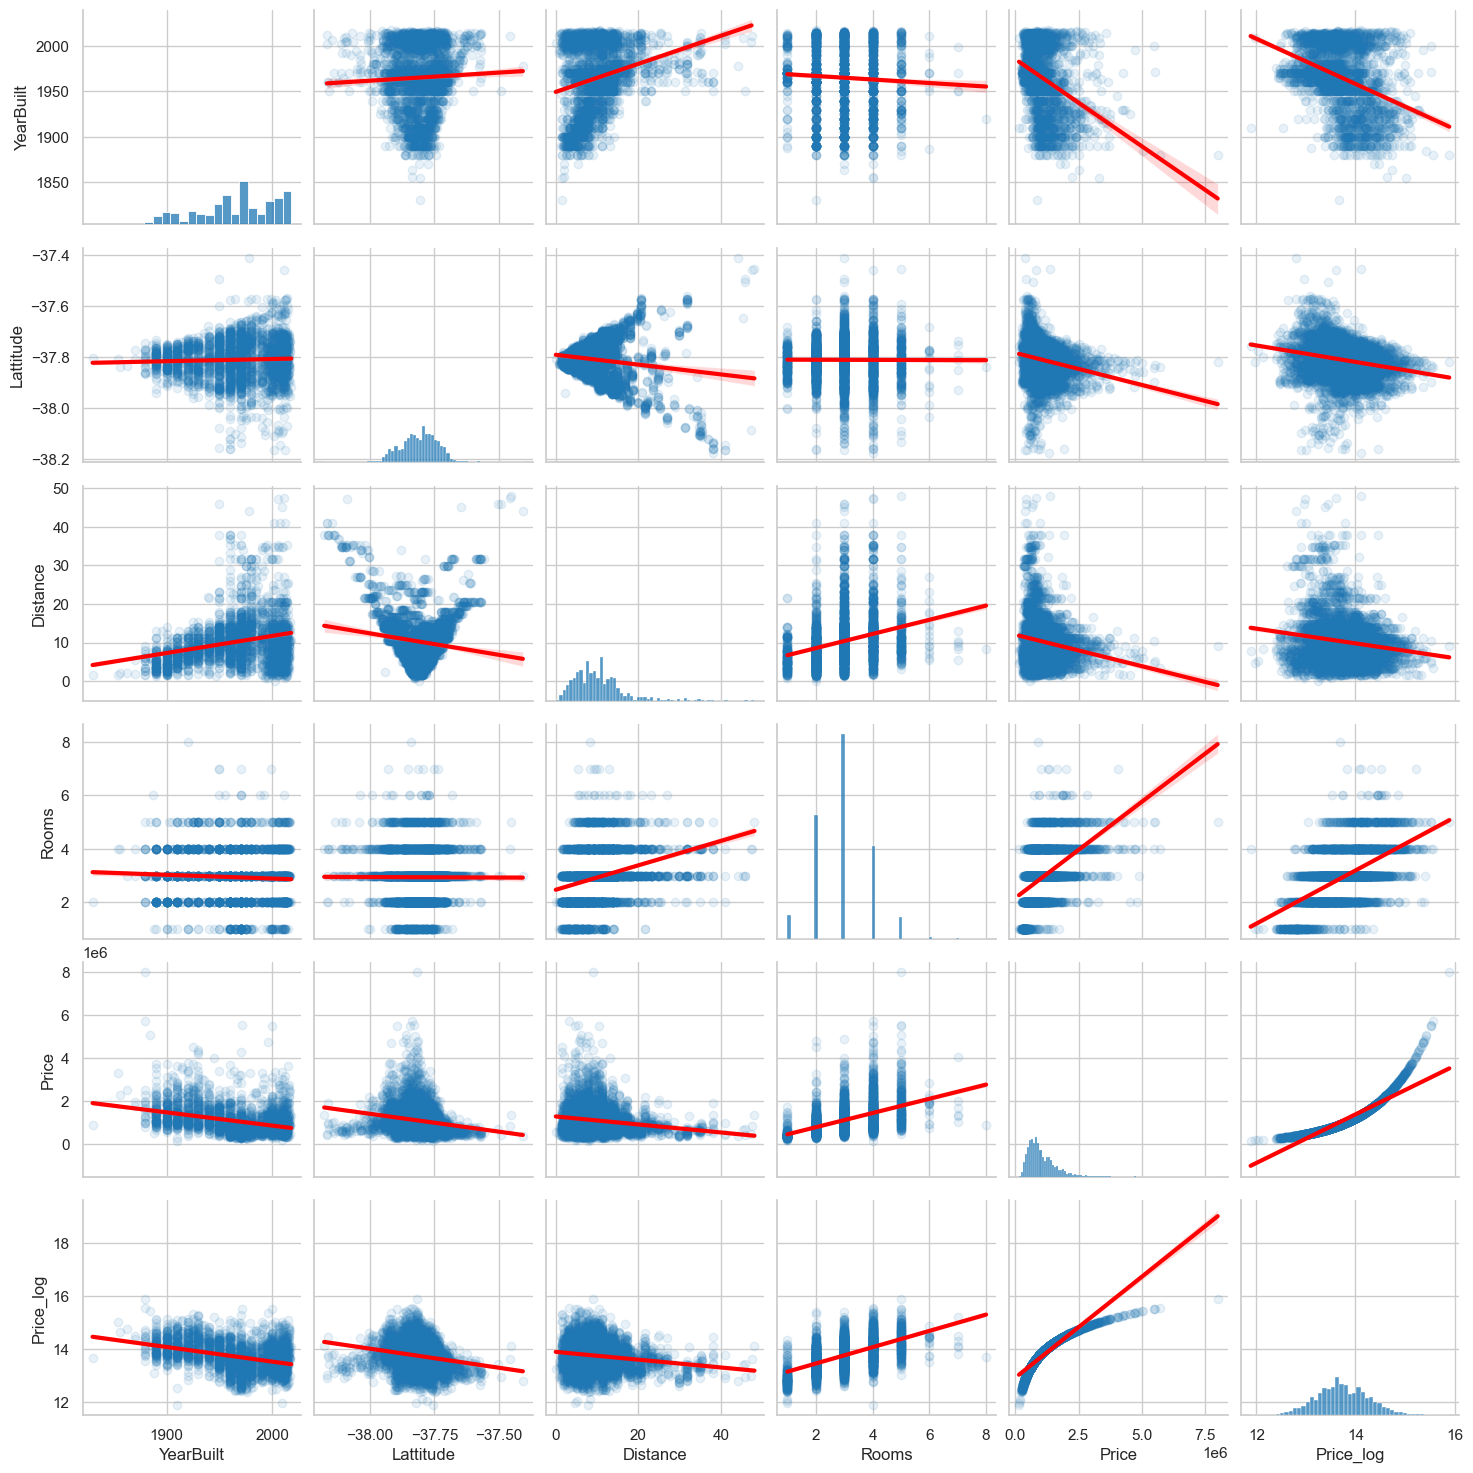

In [16]:
# Will do pair plot with most correlated values
sns.pairplot(
    train_set[corr_sorted.index[:3].tolist() + corr_sorted.index[-3:].tolist()],
    kind='reg',
    plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}}
)

## Data Processing

In [17]:
print(train_set.isnull().sum(axis=0).to_string())

Suburb              0
Address             0
Rooms               0
Type                0
Price               0
Method              0
SellerG             0
Date                0
Distance            0
Postcode            0
Bedroom2            0
Bathroom            0
Car                22
Landsize            0
BuildingArea     2182
YearBuilt        1816
CouncilArea       477
Lattitude           0
Longtitude          0
Regionname          0
Propertycount       0
price_range         0
price_range         0
Price_log           0


In [146]:
train_set_processed = train_set.copy()
valid_set_processed = valid_set.copy()
test_set_processed = test_set.copy()

### Handling NaNs

#### Car

<AxesSubplot:xlabel='Price', ylabel='Count'>

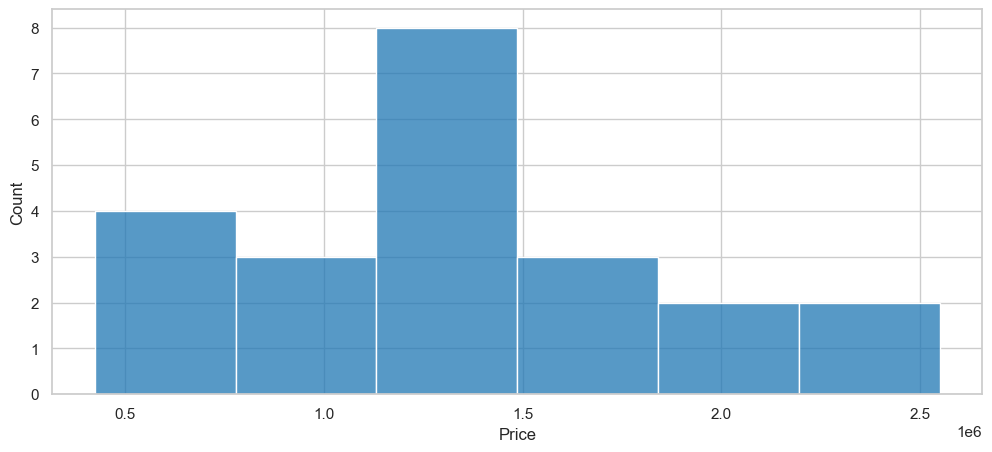

In [19]:
# How is the distribution of price when car is not set
sns.histplot(
    train_set_processed[train_set_processed.Car.isnull()]['Price']
)

In [147]:
def handle_null_car(train_df, valid_df, test_df, year_not_car: int = 1940):
    """
    We will assume that for the nulls in the year before year_not_car, are because there as effectively no car.
    
    """
    
    # For the other ones would place the median
    train_set_median = train_df['Car'].median()
    
    # For very aged houses
    train_df.loc[
        train_df['YearBuilt'] < year_not_car,
        'Car'
    ] = 0

    valid_df.loc[
        valid_df['YearBuilt'] < year_not_car,
        'Car'
    ] = 0

    test_df.loc[
        test_df['YearBuilt'] < year_not_car,
        'Car'
    ] = 0
    
    
    # And for the other houses
    train_df['Car'].fillna(train_set_median, inplace=True)
    valid_df['Car'].fillna(train_set_median, inplace=True)
    test_df['Car'].fillna(train_set_median, inplace=True)
    
    return train_df, valid_df, test_df

In [148]:
train_set_processed, valid_set_processed, test_set_processed = handle_null_car(train_set_processed, valid_set_processed, test_set_processed)

####  BuildingArea

In [122]:
def get_df_valid_size(df: pd.DataFrame, column: str):
    return df[
        (~df[column].isnull()) &
        (df[column] > 0)
    ]

In [123]:
def get_df_invalid_size(df: pd.DataFrame, column: str):
    return df[
        (df[column].isnull()) |
        (df[column] <= 0)
    ]

In [149]:
# We can see that half of the dataset is not useful
building_area_train_base = get_df_valid_size(train_set_processed, 'BuildingArea')
building_area_train_target = get_df_invalid_size(train_set_processed, 'BuildingArea')

print('Valid building area shape: ', building_area_train_base.shape)
print('Invalid building area shape: ', building_area_train_target.shape)

Valid building area shape:  (2429, 24)
Invalid building area shape:  (2188, 24)


So training a model with that amount of data that is missing i think is not be best solution.

We can try to find an easy relationship to the building area.

In [25]:
building_area_train_base.head(3)

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,price_range,price_range,Price_log
index,,,,,,,,,,,,,,,,,,,,,,,,
1845,Kensington,51 Rankins Rd,2,h,765000.0,S,Nardella,10/12/2016,4.2,3031.0,2.0,1.0,2.0,158.0,76.0,1965.0,Melbourne,-37.7902,144.9319,Northern Metropolitan,5263.0,2,2,13.547631
1609,Hawthorn East,3 Jaques St,5,h,2500000.0,VB,RT,22/08/2016,7.5,3123.0,5.0,3.0,0.0,757.0,240.0,1925.0,Boroondara,-37.8176,145.0548,Southern Metropolitan,6482.0,5,5,14.731801
1329,Brighton,95 Cochrane St,4,h,3295888.0,S,Hodges,15/10/2016,11.2,3186.0,4.0,3.0,2.0,565.0,337.0,1990.0,Bayside,-37.8975,144.9991,Southern Metropolitan,10579.0,5,5,15.008186


In [150]:
from typing import List

def create_logs(df: pd.DataFrame, columns: List[str] = ['BuildingArea', 'Rooms', 'Bedroom2', 'Bathroom', 'Car']):
    for col in columns:
        df[col + '_log'] = np.log(df[col] + 1)
    
    df.replace([np.inf, -np.inf], 0, inplace=True)

    return df

In [151]:
# And we find that there are relationships of log-log of nearly 60&
building_area_train_base = create_logs(building_area_train_base)

building_area_train_base[
    ['BuildingArea', 'BuildingArea_log', 
    'Rooms', 'Bathroom', 'Bedroom2', 'Car',
    'Rooms_log', 'Bedroom2_log', 'Bathroom_log', 'Car_log']
].corr()\
    .sort_values('BuildingArea_log')

,BuildingArea,BuildingArea_log,Rooms,Bathroom,Bedroom2,Car,Rooms_log,Bedroom2_log,Bathroom_log,Car_log
Car_log,0.054543,0.123135,0.185633,0.189973,0.200415,0.952129,0.188723,0.203586,0.198270,1.000000
Car,0.082404,0.176139,0.249816,0.211311,0.260762,1.000000,0.250283,0.261262,0.217959,0.952129
BuildingArea,1.000000,0.298051,0.102986,0.090071,0.101215,0.082404,0.093942,0.092273,0.088312,0.054543
Bathroom,0.090071,0.472635,0.600139,1.000000,0.622556,0.211311,0.570584,0.579273,0.985693,0.189973
Bathroom_log,0.088312,0.487082,0.611385,0.985693,0.621076,0.217959,0.587054,0.588788,1.000000,0.198270
Bedroom2,0.101215,0.575477,0.944879,0.622556,1.000000,0.260762,0.932731,0.980448,0.621076,0.200415
Bedroom2_log,0.092273,0.581451,0.931077,0.579273,0.980448,0.261262,0.948541,1.000000,0.588788,0.203586
Rooms,0.102986,0.591785,1.000000,0.600139,0.944879,0.249816,0.983660,0.931077,0.611385,0.185633
Rooms_log,0.093942,0.597784,0.983660,0.570584,0.932731,0.250283,1.000000,0.948541,0.587054,0.188723
BuildingArea_log,0.298051,1.000000,0.591785,0.472635,0.575477,0.176139,0.597784,0.581451,0.487082,0.123135


So for this model, seems the variables that have great influence in the building area log are:
- Car
- Bathroom Logarithm
- Bedroom2 Logarithm
- Rooms Logarithm

In [152]:
building_area_features = ['Car', 'Bathroom_log', 'Bedroom2_log', 'Rooms_log']

In [153]:
Y_building_area_train_base = building_area_train_base.BuildingArea_log
X_building_area_train_base = building_area_train_base[building_area_features]

In [154]:
building_area_scaler = StandardScaler()
X_building_area_train_base = building_area_scaler.fit_transform(X_building_area_train_base)

In [155]:
# Huber Regressor is robust agains outliers
ba_linear_model = HuberRegressor()

In [156]:
ba_linear_model.fit(X_building_area_train_base, Y_building_area_train_base)

HuberRegressor()

In [157]:
# Can see in the train set which is r2 scoring
from sklearn.metrics import r2_score
round(r2_score(Y_building_area_train_base, ba_linear_model.predict(X_building_area_train_base)), 2)

0.38

And now we will use this model to imput the missing values in the building area.

In [158]:
from copy import deepcopy

def input_nan_logarithms(
    model, 
    scaler, 
    df: pd.DataFrame, 
    column_target: str, 
    column_features,
    log: bool = True
):
    
    """
    Input the nans with a given model with the linear regression model for logarithms.
    Also, computes the MSE for the base dataframe (the one without nan).
    - model: the model trained
    - scaler: StandardScaler fitted
    - df: the dataframe for which we want to replace the nans
    - column_target: for which column do we want to replace the NaNs
    - column_features: list of features used from the df
    """
    df = deepcopy(df)
    
    # Get the valid and invalid dataframes
    base_df = get_df_valid_size(df, column_target)
    target_df = get_df_invalid_size(df, column_target)
    
    # Create the log features
    base_df = create_logs(base_df)
    target_df = create_logs(target_df)
    
    # Apply scaling
    Y_base_df = base_df[column_target + '_log']  # we expect the log of that variable
    X_base_df = base_df[column_features]
    X_base_df = scaler.transform(X_base_df)
    
    X_target_df = target_df[column_features]
    X_target_df = scaler.transform(X_target_df)
    Y_target_df_idx = target_df.index.values

    # And now we make the predictions
    prediction_base = model.predict(X_base_df)
    prediction_target = model.predict(X_target_df)
    
    # We compute scoring on the base
    comparison = np.exp(Y_base_df), np.exp(prediction_base)
    
    # Compute accuracy on the base
    if log:
        print('-'*20)
        print('MSE error: ', mean_squared_error(
            *comparison,
            squared=False
        ))

        print('R2 error: ', r2_score(
            *comparison,
        ))
        print('-'*20)
    
    # And finally we fill with the exponential
    df.loc[
        Y_target_df_idx,
        column_target
    ] = np.exp(prediction_target)
    
    return df

In [159]:
train_set_processed = input_nan_logarithms(ba_linear_model, building_area_scaler, train_set_processed, 'BuildingArea', building_area_features, log=False)
valid_set_processed = input_nan_logarithms(ba_linear_model, building_area_scaler, valid_set_processed, 'BuildingArea', building_area_features)
test_set_processed = input_nan_logarithms(ba_linear_model, building_area_scaler, test_set_processed, 'BuildingArea', building_area_features)

--------------------
MSE error:  69.52603252744271
R2 error:  0.3736920793256484
--------------------
--------------------
MSE error:  65.35100789196404
R2 error:  0.4321189081638367
--------------------


#### Landsize

Same analysis as before, but could include now the Building area & building area logs

#### CouncilArea

Will can try to use a **k-nearest neighbor**, as the council area depends a lot in the position of longtitude and lattitude.

In [ ]:
train_set_processed.head(3)

In [ ]:
test_set_processed.isnull().sum(axis=0)

In [ ]:
train_set_base = train_set_processed.dropna(subset=['CouncilArea'])
train_set_target = train_set_processed[train_set_processed['CouncilArea'].isna()]

# Explicative variables
X_train_base_set_council = train_set_base[['Lattitude', 'Longtitude']]
X_train_target_set_council = train_set_target[['Lattitude', 'Longtitude']]
X_train_target_set_council_index = X_train_target_set_council.index

# Target variables
Y_train_base_set_council = train_set_base['CouncilArea'].values.ravel()

In [ ]:
# Scale the inputs
scaler = StandardScaler()

X_train_base_set_council = scaler.fit_transform(X_train_base_set_council)
X_train_target_set_council = scaler.transform(X_train_target_set_council)

In [ ]:
# Train the model
n_council_area = train_set_processed['CouncilArea'].nunique()
knn_council_area = KNeighborsClassifier(n_council_area)

knn_council_area.fit(X_train_base_set_council, Y_train_base_set_council)

In [ ]:
accuracy_score(knn_council_area.predict(X_valid_base_set_council), Y_valid_base_set_council)

We can see that this is not giving us very good results.

In [ ]:
train_set_processed['CouncilArea'].value_counts()

In [ ]:
train_set_processed['CouncilArea'].fillna('Unknown', inplace=True)
valid_set_processed['CouncilArea'].fillna('Unknown', inplace=True)
test_set_processed['CouncilArea'].fillna('Unknown', inplace=True)